<a href="https://colab.research.google.com/github/andreidore/recipes/blob/main/recipies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 56.8 MB/s 
     |████████████████████████████████| 895 kB 51.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.3 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [10]:
df=pd.read_csv("recipes.csv",sep=";")

In [11]:
df.head()

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007


In [13]:
df=df[["Ingredients","Directions"]]
df.head()

,Ingredients,Directions
0,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ..."
1,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...
2,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....
3,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....
4,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...


In [14]:
df.shape

(12351, 2)

In [23]:
df.dropna(inplace=True)

In [24]:
df.shape

(12345, 2)

In [16]:
df["Ingredients"].nunique()

12097

0      669
1      529
2      328
3      360
4      321
5      564
6      723
7      169
8      386
9      329
10     440
11     250
12     805
13     658
14     466
15     852
16     362
17    1061
18     108
19     136
Name: Directions, dtype: int64


(array([3.528e+03, 6.000e+03, 2.102e+03, 5.060e+02, 1.360e+02, 4.500e+01,
        2.000e+01, 4.000e+00, 3.000e+00, 1.000e+00]),
 array([  33. ,  328.1,  623.2,  918.3, 1213.4, 1508.5, 1803.6, 2098.7,
        2393.8, 2688.9, 2984. ]),
 <a list of 10 Patch objects>)

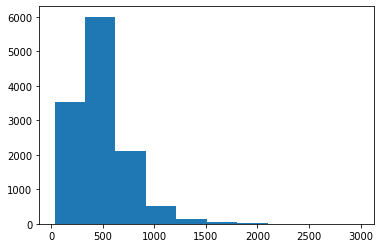

In [31]:
directions_len=df["Directions"].apply(len)
print(directions_len[:20])
plt.hist(directions_len)